In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/MVA/graph_mlc/src


In [3]:
from util import *
from params import *
from imports import *

from data.dataset import *
from data.transforms import *

from model_zoo.common import *
from model_zoo.baseline import *

from training.train import *
from training.freezing import *

In [4]:
seed_everything(SEED)

# Data

In [5]:
imgs = os.listdir(IMG_PATH)

In [6]:
train_dataset = MLCDataset(TRAIN_IMGS, 
                           transforms=get_transfos(size=IMG_SIZE),
                           img_path=IMG_PATH,
                           annotation_path=ANNOTATION_PATH
                          )

In [7]:
trainval_dataset = MLCDataset(TRAINVAL_IMGS, 
                              transforms=get_transfos(size=IMG_SIZE),
                              img_path=IMG_PATH,
                              annotation_path=ANNOTATION_PATH
                             )

In [8]:
val_dataset = MLCDataset(VAL_IMGS, 
                         transforms=get_transfos(test=True, size=IMG_SIZE),
                         img_path=IMG_PATH,
                         annotation_path=ANNOTATION_PATH
                        )

In [9]:
test_dataset = MLCDataset(TEST_IMGS, 
                          transforms=get_transfos(test=True, size=IMG_SIZE),
                          img_path=IMG_PATH,
                          annotation_path=ANNOTATION_PATH
                         )

In [10]:
print('Number of training images :', len(train_dataset))
print('Number of validation images :', len(val_dataset))
print('Number of testing images :', len(test_dataset))

Number of training images : 2501
Number of validation images : 2510
Number of testing images : 4952


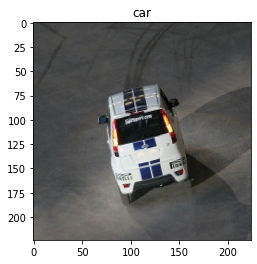

In [11]:
img, label = train_dataset[0]
try:
    img = img.numpy()
except:
    pass
img = np.clip(img * STD[:, np.newaxis, np.newaxis] + MEAN[:, np.newaxis, np.newaxis], 0, 1)
plt.imshow(img.transpose(1, 2, 0))
plt.title(" ,".join([CLASSES[i] for i, l in enumerate(label) if l]))
plt.show()

# Model

In [12]:
def train_baseline(backbone, train_dataset, val_dataset, test_dataset=None, 
                   cp=False, model_name='model', threshold=0.5):
    
    model = Classifier(backbone, NUM_CLASSES).cuda()

    print('\n- Training logits only : ')

    freeze(model)
    unfreeze_layer(model, 'logit')
    n_parameters = count_parameters(model)
    print(f'    -> {n_parameters} trainable parameters\n')

    fit(model, train_dataset, val_dataset, epochs=3, batch_size=32, warmup_prop=0, lr=1e-3, min_lr=1e-4,
        verbose=1, verbose_eval=1, cp=False, model_name='model')

    print('\n- Training all layers: ')

    if backbone == 'resnet34':
        unfreeze(model)
    else:
        unfreeze_layer(model, 'layer4')
        
    n_parameters = count_parameters(model)
    print(f'    -> {n_parameters} trainable parameters\n')

    fit(model, train_dataset, val_dataset, epochs=5, batch_size=8, warmup_prop=0, lr=1e-4, min_lr=1e-6,
        verbose=1, verbose_eval=1, cp=cp, model_name=model_name)

    print('\n- Evaluating: \n')

    if cp:
        load_model_weights(model, model_name, verbose=1)
        
    pred_val = predict_voc(model, val_dataset)
    print(f' - Scored {voc12_mAP(pred_val) :.3f} on validation data')
    aps = voc12_mAP(pred_val, return_aps=True)
    
    if test_dataset is not None:
        pred_test = predict_voc(model, test_dataset)
        print(f' - Scored {voc12_mAP(pred_test) :.3f} on test data\n')
        
    torch.cuda.empty_cache()
    return model, aps

In [13]:
backbone = 'resnet34'
# backbone = 'resnet101'
# backbone = 'resnext101'

In [14]:
%%time
model, aps = train_baseline(backbone, trainval_dataset, test_dataset, model_name=backbone)


- Training logits only : 
    -> 10260 trainable parameters

Epoch 1/3 	 lr=1.0e-03 	 t=14s 	 loss=0.221 	 mAP=0.681 	 val_loss=0.132 	 
Epoch 2/3 	 lr=5.5e-04 	 t=14s 	 loss=0.135 	 mAP=0.736 	 val_loss=0.113 	 
Epoch 3/3 	 lr=1.0e-04 	 t=14s 	 loss=0.123 	 mAP=0.744 	 val_loss=0.110 	 

- Training all layers: 
    -> 21294932 trainable parameters

Epoch 1/5 	 lr=1.0e-04 	 t=27s 	 loss=0.132 	 mAP=0.794 	 val_loss=0.106 	 
Epoch 2/5 	 lr=8.6e-05 	 t=27s 	 loss=0.101 	 mAP=0.808 	 val_loss=0.098 	 
Epoch 3/5 	 lr=5.1e-05 	 t=27s 	 loss=0.073 	 mAP=0.839 	 val_loss=0.088 	 
Epoch 4/5 	 lr=1.5e-05 	 t=27s 	 loss=0.056 	 mAP=0.849 	 val_loss=0.083 	 
Epoch 5/5 	 lr=1.0e-06 	 t=27s 	 loss=0.049 	 mAP=0.850 	 val_loss=0.082 	 

- Evaluating: 

 - Scored 0.850 on validation data
CPU times: user 2min 31s, sys: 23.9 s, total: 2min 55s
Wall time: 3min 10s


In [15]:
# np.save('../output/aps_baseline_resnet34_576.npy', np.array(aps))

In [16]:
 model.logit

Linear(in_features=512, out_features=20, bias=True)

In [17]:
clfs = model.logit.weight.cpu().detach().numpy()
colors = ['r', 'r', 'g', 'r', 'b', 'r', 'r', 'g', 'b', 'g', 'b', 'g', 'g', 'r', 'g', 'b', 'g', 'b', 'r', 'b']

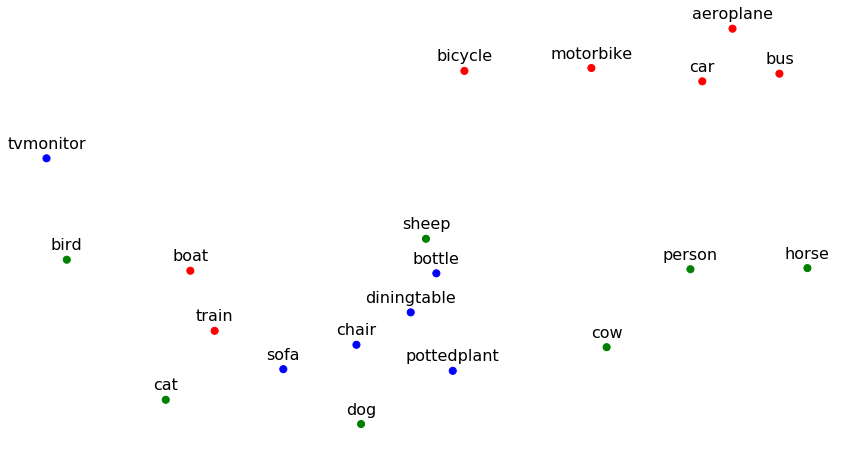

In [59]:
rep = TSNE(n_components=2, perplexity=1, early_exaggeration=2, random_state=SEED).fit_transform(clfs)

plt.figure(figsize=(15, 8))
plt.scatter(rep[:, 0], rep[:, 1], c=colors, s=50)

for i, c in enumerate(CLASSES):
    plt.annotate(c, (rep[i, 0], rep[i, 1] + 50), ha='center', fontsize=16)
    
plt.axis(False)
plt.show()